In [73]:
from IPython.display import display
import numpy as np
# import modin.pandas as pd
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simsun', 'Arial']})
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})
%matplotlib inline

# np.random.seed(4590)
nf_data_path = r'../../Data/noFinacialFeatures.csv'
f_data_path = r'../../Data/FinacialFeatures.csv'

In [74]:
nf_df = pd.read_csv(nf_data_path)
nf_df.head(5)

,企业编号,企业总评分,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,资质证书数量,...,票面利率（%）_max,票面利率（%）_min,票面利率（%）_std,计划发行总额（亿元）_sum,计划发行总额（亿元）_max,计划发行总额（亿元）_min,计划发行总额（亿元）_std,城镇职工基本养老保险人数,保险实缴/人数,基数/人数
0,1001,75.374276,1.0,1.0,1.0,1.0,2.0,1.0,1.0,9.0,...,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,2176,17910.412479,43390.918022
1,1002,79.830122,2.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,...,4.35,3.05,0.712039,38.0,10.0,3.0,2.943920,2176,17910.412479,43390.918022
2,1003,78.318264,2.0,0.0,1.0,1.0,1.0,0.0,1.0,442.0,...,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,2176,17910.412479,43390.918022
3,1004,83.253376,0.0,6.0,1.0,0.0,0.0,2.0,1.0,1.0,...,5.50,3.88,0.580836,29.0,10.0,4.0,2.387467,2176,17910.412479,43390.918022
4,1005,83.291493,6.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,...,5.30,3.30,0.628865,70.0,10.0,3.0,2.943920,2176,17910.412479,43390.918022


In [78]:
f_df = pd.read_csv(f_data_path)
f_df.head(5)

,企业编号,企业总评分,资产:流动资产合计(元)_mean_x,资产:流动资产合计(元)_max_x,资产:流动资产合计(元)_min_x,资产:流动资产合计(元)_std_x,资产:流动资产合计(元)滚动增长_mean_x,资产:资产总计(元)_mean_x,资产:资产总计(元)_max_x,资产:资产总计(元)_min_x,...,应收账款周转天数(天)_mean,应收账款周转天数(天)_max,应收账款周转天数(天)_min,应收账款周转天数(天)_std,应收账款周转天数(天)滚动增长_mean,存货周转天数(天)_mean,存货周转天数(天)_max,存货周转天数(天)_min,存货周转天数(天)_std,存货周转天数(天)滚动增长_mean
0,1001,75.374276,37.138558,102.982866,-3.422013,45.402146,0.526979,5.236450,10.129814,0.418085,...,107.589270,191.707773,63.791689,44.495607,0.151392,414.778035,1089.655763,176.283983,325.371499,1.562757
1,1002,79.830122,53.649848,102.805115,-40.517576,70.738587,-0.250285,28.653568,44.691555,16.642118,...,46.903333,56.590000,39.830000,6.234116,0.023916,6.506667,7.040000,5.010000,0.702335,0.045330
2,1003,78.318264,-0.078404,23.757798,-18.510366,16.111779,-2.589393,-9.319352,15.939361,-24.609220,...,84.275556,139.910000,56.020000,33.143654,-0.040224,54.918889,75.540000,38.010000,11.089465,0.031792
3,1004,83.253376,43.189113,105.787782,1.316974,47.110533,15.573363,2.084637,7.893039,-2.714605,...,26.720000,35.360000,17.290000,6.024438,0.081857,6.954444,7.900000,6.240000,0.618448,0.021711
4,1005,83.291493,-8.351909,40.883944,-36.417633,32.154606,-0.489689,26.580415,34.378493,19.680974,...,94.050000,110.260000,77.850000,9.652235,0.012921,108.584444,357.190000,44.160000,101.728838,0.344086


In [79]:
df = pd.DataFrame()
df = nf_df.copy()
f_df.drop(['企业总评分'], axis=1, inplace=True)
df = df.merge(f_df, how='left', on='企业编号')
df.head(5)

,企业编号,企业总评分,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,资质证书数量,...,应收账款周转天数(天)_mean,应收账款周转天数(天)_max,应收账款周转天数(天)_min,应收账款周转天数(天)_std,应收账款周转天数(天)滚动增长_mean,存货周转天数(天)_mean,存货周转天数(天)_max,存货周转天数(天)_min,存货周转天数(天)_std,存货周转天数(天)滚动增长_mean
0,1001,75.374276,1.0,1.0,1.0,1.0,2.0,1.0,1.0,9.0,...,107.589270,191.707773,63.791689,44.495607,0.151392,414.778035,1089.655763,176.283983,325.371499,1.562757
1,1002,79.830122,2.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,...,46.903333,56.590000,39.830000,6.234116,0.023916,6.506667,7.040000,5.010000,0.702335,0.045330
2,1003,78.318264,2.0,0.0,1.0,1.0,1.0,0.0,1.0,442.0,...,84.275556,139.910000,56.020000,33.143654,-0.040224,54.918889,75.540000,38.010000,11.089465,0.031792
3,1004,83.253376,0.0,6.0,1.0,0.0,0.0,2.0,1.0,1.0,...,26.720000,35.360000,17.290000,6.024438,0.081857,6.954444,7.900000,6.240000,0.618448,0.021711
4,1005,83.291493,6.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,...,94.050000,110.260000,77.850000,9.652235,0.012921,108.584444,357.190000,44.160000,101.728838,0.344086


In [81]:
y = df[['企业编号', '企业总评分']]
x = df.drop(['企业总评分'], axis=1)

In [83]:
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=0)
ytrain_id = ytrain['企业编号']
ytrain = ytrain['企业总评分']
ytest_id = ytest['企业编号']
ytest = ytest['企业总评分']
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((2364, 322), (592, 322), (2364,), (592,))

In [84]:
xtrain.head(5)

,企业编号,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,资质证书数量,android,...,应收账款周转天数(天)_mean,应收账款周转天数(天)_max,应收账款周转天数(天)_min,应收账款周转天数(天)_std,应收账款周转天数(天)滚动增长_mean,存货周转天数(天)_mean,存货周转天数(天)_max,存货周转天数(天)_min,存货周转天数(天)_std,存货周转天数(天)滚动增长_mean
1547,2574,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,...,54.442222,81.72,37.76,19.800624,-0.035790,94.313333,175.92,30.22,58.951289,-0.067428
119,1121,0.0,0.0,2.0,2.0,0.0,0.0,0.0,8.0,0.0,...,121.655556,156.98,88.91,17.353128,0.015472,125.791667,221.92,77.28,45.120232,0.005389
2701,3745,22.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,96.008889,118.56,42.92,25.293863,-0.027840,2.306667,3.18,1.46,0.655038,0.136693
1450,2475,6.0,4.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,...,142.906111,343.31,10.25,120.287790,0.166476,437.723889,1111.39,113.25,301.697398,0.233617
2400,3441,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,70.657778,84.38,65.87,5.571395,0.009875,2466.996667,2753.71,2203.02,175.901682,-0.002600


In [85]:
id_train = xtrain['企业编号']
id_test = xtest['企业编号']
xtrain.drop(['企业编号'], axis=1, inplace=True)
xtest.drop(['企业编号'], axis=1, inplace=True)
xtrain.head(5)

,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,资质证书数量,android,ios,...,应收账款周转天数(天)_mean,应收账款周转天数(天)_max,应收账款周转天数(天)_min,应收账款周转天数(天)_std,应收账款周转天数(天)滚动增长_mean,存货周转天数(天)_mean,存货周转天数(天)_max,存货周转天数(天)_min,存货周转天数(天)_std,存货周转天数(天)滚动增长_mean
1547,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,...,54.442222,81.72,37.76,19.800624,-0.035790,94.313333,175.92,30.22,58.951289,-0.067428
119,0.0,0.0,2.0,2.0,0.0,0.0,0.0,8.0,0.0,0.0,...,121.655556,156.98,88.91,17.353128,0.015472,125.791667,221.92,77.28,45.120232,0.005389
2701,22.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,96.008889,118.56,42.92,25.293863,-0.027840,2.306667,3.18,1.46,0.655038,0.136693
1450,6.0,4.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,...,142.906111,343.31,10.25,120.287790,0.166476,437.723889,1111.39,113.25,301.697398,0.233617
2400,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,70.657778,84.38,65.87,5.571395,0.009875,2466.996667,2753.71,2203.02,175.901682,-0.002600


In [54]:
# sc_X = StandardScaler()
# xtrain = sc_X.fit_transform(xtrain)
# xtest = sc_X.transform(xtest)
# xtrain, xtest
# xtrain = (xtrain - xtrain.mean())/xtrain.std(ddof=0)
# xtest = (xtest - xtest.mean())/xtest.std(ddof=0)
# xtrain.head(5)

,软著数量,作品著作数量,项目数量,纳税A级年份_2014,纳税A级年份_2015,纳税A级年份_2016,纳税A级年份_2017,资质证书数量,android,ios,...,票面利率（%）_max,票面利率（%）_min,票面利率（%）_std,计划发行总额（亿元）_sum,计划发行总额（亿元）_max,计划发行总额（亿元）_min,计划发行总额（亿元）_std,城镇职工基本养老保险人数,保险实缴/人数,基数/人数
1547,-0.203594,-0.068641,-4.233534,0.832237,0.638870,0.243157,0.613693,-0.096530,0.308585,-0.20734,...,-0.528000,-0.517297,-0.328897,-0.201036,-0.302501,-0.325992,-0.215355,-0.006253,0.005109,0.005861
119,-0.203594,-0.068641,4.386685,2.770570,-1.058084,-0.977275,-1.192995,-0.061086,-0.182657,-0.20734,...,1.076883,1.348701,-0.328897,-0.122108,-0.118054,0.058950,-0.215355,0.192242,-0.759376,-0.391645
2701,0.161024,-0.068641,0.076576,0.832237,-1.058084,0.243157,-1.192995,-0.096530,-0.182657,-0.20734,...,-0.528000,-0.517297,-0.328897,-0.201036,-0.302501,-0.325992,-0.215355,-0.129084,-0.059168,0.279804
1450,-0.104153,-0.028693,4.386685,2.770570,-1.058084,-0.977275,2.420380,-0.096530,-0.182657,-0.20734,...,-0.528000,-0.517297,-0.328897,-0.201036,-0.302501,-0.325992,-0.215355,-0.128616,-0.166426,0.345097
2400,-0.203594,-0.068641,0.076576,0.832237,0.638870,0.243157,0.613693,-0.092099,-0.182657,-0.20734,...,-0.528000,-0.517297,-0.328897,-0.201036,-0.302501,-0.325992,-0.215355,-0.043588,-1.617738,-1.379351


In [67]:
nfolds = 10
folds = KFold(n_splits=nfolds, shuffle=True, random_state=15)

In [68]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30,
         'objective': 'regression',
         'max_depth': 10,
         'learning_rate': 0.005,
         "min_child_samples": 100,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

In [69]:
feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
mvalid = np.zeros(len(xtrain))
mfull = np.zeros(len(xtest))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0, y0 = xtrain.iloc[trn_idx], ytrain.iloc[trn_idx]
    x1, y1 = xtrain.iloc[val_idx], ytrain.iloc[val_idx]

    trn_data = lgb.Dataset(x0, label=y0)
    val_data = lgb.Dataset(x1, label=y1)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data],
                    verbose_eval=500, early_stopping_rounds=150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(xtest,
                         num_iteration=clf.best_iteration) / folds.n_splits

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.55833	valid_1's rmse: 2.95484
Early stopping, best iteration is:
[772]	training's rmse: 2.30175	valid_1's rmse: 2.92286
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.53189	valid_1's rmse: 3.29218
[1000]	training's rmse: 2.13319	valid_1's rmse: 3.24127
Early stopping, best iteration is:
[918]	training's rmse: 2.17717	valid_1's rmse: 3.24091
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.55412	valid_1's rmse: 3.13398
Early stopping, best iteration is:
[830]	training's rmse: 2.25068	valid_1's rmse: 3.09448
----
fold n°3
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.54117	valid_1's rmse: 3.32394
[1000]	training's rmse: 2.14103	valid_1's rmse: 3.25592
Early stopping, best iteration is:
[1151]	training's rmse: 2.06237	valid_1's rmse: 3.25394

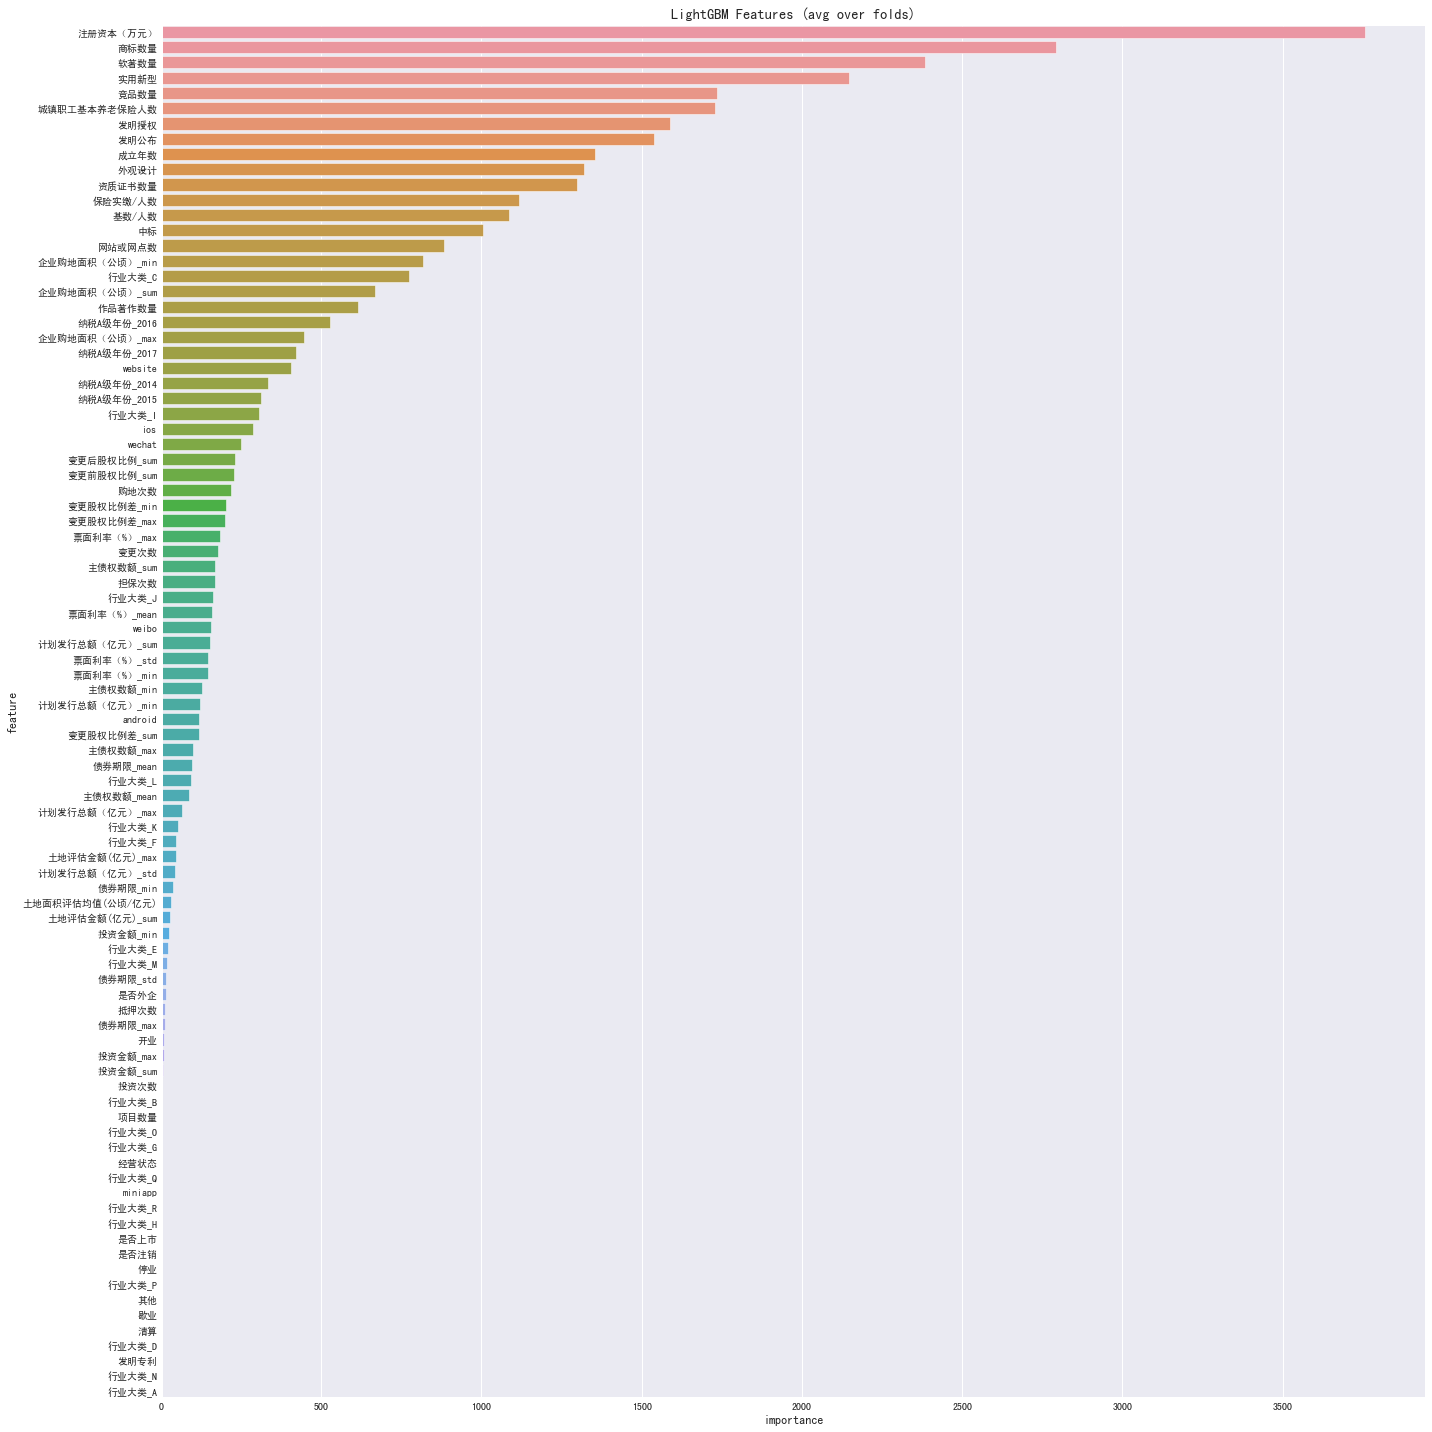

In [71]:
ximp = pd.DataFrame()
ximp['feature'] = xtrain.columns
ximp['importance'] = feature_importance_df.mean(axis=1)

plt.figure(figsize=(20, 20))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance",
                                  ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [72]:
np.sqrt(mean_squared_error(mfull.astype(int), ytest.astype(int)))

3.058274111413256

In [ ]:
xsub = pd.DataFrame()
xsub['企业编号'] = id_test
xsub['企业总评分'] = mfull.astype(int)
xsub.to_csv('sub_lgb_scaling.csv', index=False)